# Kaggle Project - Home Price Advanced Regression Techniques
# Part 2 - EDA

This section explores the data through data visualization. Certain needed data transformation (e.g., Johnson SU transformation for normalize data), feature engineering, and data manipulation are performed for exploration are performed in this section. The outcome of the exporation is to advise the proper data pre-processing and modeling strategies.

### Table of Content
1. [Import Libraries](#Step-1-Import_libraries)
2. [Load Data from Part 1](#Step-2-Load-Data-from-Part-1)
3. [Data Separation](#Step-3-Data-Separation)
4. [Numerical Feature Transformation](#Step-4-Numerical-Feature-Transformation)
5. [Categorical Feature Encoding](#Step-5-Categorical-Feature-Encoding)
6. [Correlation](#Step-6-Correlation)
7. [Store Features](#Step-7-Store-Features)


### Summary:

1. **Numerical Feature/Label Transformation**
The [histogram](#Step-4-Numerical-Feature-Transformation) shows that the data for the following features/label are not normally distributed. PowerTransformer (i.e., transform with Johnson SU;  distribution) can help transform the distribution to normal.

             ['LotFrontage', 
              'LotArea', 
              'BsmtFinSF1', 
              'BsmtFinSF2', 
              'BsmfUnfSF', 
              'TotalBsmtSF', 
              '1stFlrSF', 
              '2ndFlrSF', 
              'LowQualFinSF', 
              'GrLivArea',
              'GarageArea']
              ['SalePrice']
          
2. **Categorical Feature Encoding** 

The [Analysis of Variance (ANOVA)](#5.2---1-Way-ANOVA) test shows the partition of variance of the most categorical features are statistically significant. Therefore, this project propose to encoded these features based on the mean of the `SalePrice`. The `'LandSlope', 'Street', 'Utilities'` are removed due to either:
**a.** partition of variance are not statistically significant, or
**b.** highly unbalanced level (no enough information to learn from).

3. **Feature Engineering with Polynomial Terms**

Based on the [pairplot](#6.3---Pairplot), the regression model may benefit from by adding the 3rd degree polynomial terms for the following features, though at the risk of model overfitting.

            ['BldgType',
             'ExterCond',
             'Exterior2nd',
             'BsmtExposure',
             'BsmtFinType1',
             'BsmtFinType2',
             'Fence'
             'Functional',
             'PoolQC',
             'SaleCondition',
             'Heating',
             'GarageQual',
             'GarageCond',
             'MiscFeature']

4. **Proposed Model Algorithm**

Based on the [**heatmap**](#6.2---Heatmap), many featuers are correlated among each other. Therefore, the following three modeling appraoches are proposed.
>- Linear Regression with feature selection through LASSO regularization (auto-feature-selection)

## Step-1 Import Libraries

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import PowerTransformer
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

%matplotlib inline

## Step-2 Load Data from Part 1

In [14]:
%store -r train
%store -r test

# model feedback from Part 4 for tuning
%store -r data_for_removal

In [15]:
print(data_for_removal)

[179, 186, 219, 314, 379, 474, 589, 609, 633, 689, 692, 770, 775, 799, 804, 899, 1047, 1170, 1182, 1183, 1325]


## Step-3 Data Separation

### 3.0 - Remove Outliers & Model Tuning (from feedback)

#### Remove Outliers

<Figure size 864x864 with 0 Axes>

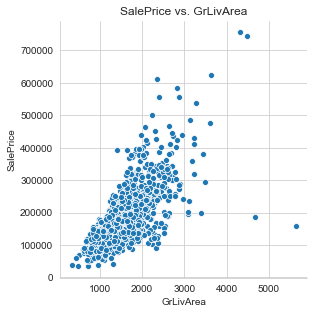

In [16]:
# Visualize Outlier. Note that this step was added after the initial run with Lasso regression.
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(12, 12))
    sns.relplot(data=train, x='GrLivArea', y='SalePrice')
    plt.title('SalePrice vs. GrLivArea')
    plt.tight_layout(pad=3)
    plt.show();

Based on the scatter plot, two properties with very larger size were sold at abnormal cheap prices. Find and remove these two properties.

In [17]:
train[['GrLivArea', 'SalePrice']].sort_values(by='GrLivArea', ascending=False).head()

GrLivArea  SalePrice
Id                        
1299       5642     160000
524        4676     184750
1183       4476     745000
692        4316     755000
1170       3627     625000

Remove property with id `1299` and `524`

In [18]:
print(f'Total data before drop: {train.shape[0]}.')
train.drop([1299, 524], inplace=True)
print(f'Total data after drop: {train.shape[0]}.')

Total data before drop: 1460.
Total data after drop: 1458.


#### Data Tuning

In [19]:
# print(f'Total data before drop: {train.shape[0]}.')
# train.drop(data_for_removal, inplace=True)
# print(f'Total data after drop: {train.shape[0]}.')

### 3.1 - X and y

In [20]:
X = train.drop(columns='SalePrice')
y = train[['SalePrice']]
print(X.shape)
print(y.shape)
print(y.isnull().sum()) # check missing value for `SalePrice`

(1458, 79)
(1458, 1)
SalePrice    0
dtype: int64


### 3.2 - Split Numerical and Categorical

In [21]:
# Numerical & Categorial Columns
num_feats = [column for column in X.columns if X.dtypes[column] != 'O']
cat_feats = [column for column in X.columns if X.dtypes[column] == 'O']

# Separate Num & Cat data then add label
X_num = X[num_feats]
X_cat = X[cat_feats]

# check df size
print(X_num.shape)
print(X_cat.shape)

(1458, 36)
(1458, 43)


There are 36 numerical features and 43 categorical features.

## Step-4 Numerical Feature Transformation

Observe the distribution of the data and determine whether transformation is necessary.

### 4.1 - `SalePrice`

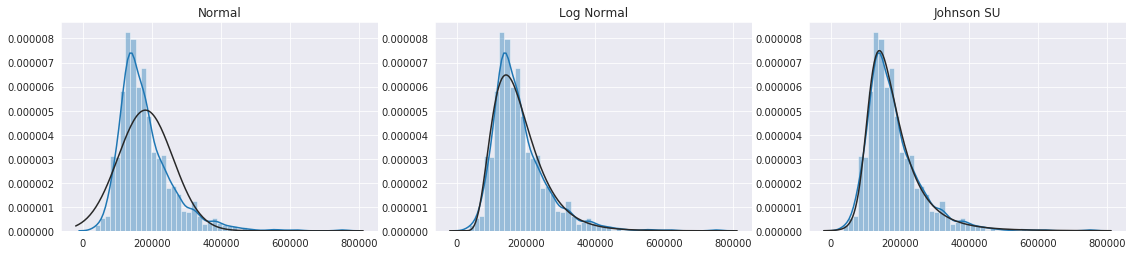

In [22]:
with sns.axes_style("darkgrid"):
    fig, axes = plt.subplots(1, 3, figsize=(16, 4))
    plt.tight_layout(pad=3)
    sns.distplot(y, fit=stats.norm, ax=axes[0])
    axes[0].set_title('Normal')
    sns.distplot(y, fit=stats.lognorm, ax=axes[1])
    axes[1].set_title('Log Normal')
    sns.distplot(y, fit=stats.johnsonsu, ax=axes[2])
    axes[2].set_title('Johnson SU');

Based on the above plots, the `SalePrice` data is right skewed. **Johnson Distribution**, the default option for `PowerTransformer` fits the best. Transform the `SalePrice` using **Johnson Distribution**.

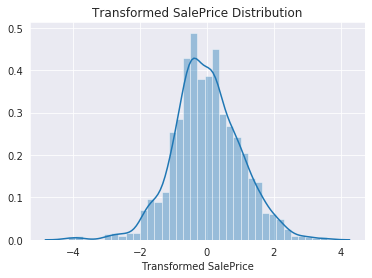

In [23]:
# Transform y
pt = PowerTransformer(method='yeo-johnson', # Johnson transformation
                      standardize=True,     # zero mean
                      copy=True)           # False = inplace transform
y = pt.fit_transform(y)

# Plot y after transformation
with sns.axes_style("darkgrid"):
    sns.distplot(y);
    plt.title('Transformed SalePrice Distribution')
    plt.xlabel('Transformed SalePrice')

### 4.2 - Numerical Features

In [24]:
# Fill NaN with 0
X_num.fillna(value=0, inplace=True);

/Users/kaizhao/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


/Users/kaizhao/anaconda3/lib/python3.7/site-packages/scipy/stats/_continuous_distns.py:3519: RuntimeWarning: divide by zero encountered in log
  trm = _norm_pdf(a + b * np.log(x + np.sqrt(x2+1)))
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:1625: RuntimeWarning: divide by zero encountered in log
  return log(self._pdf(x, *args))


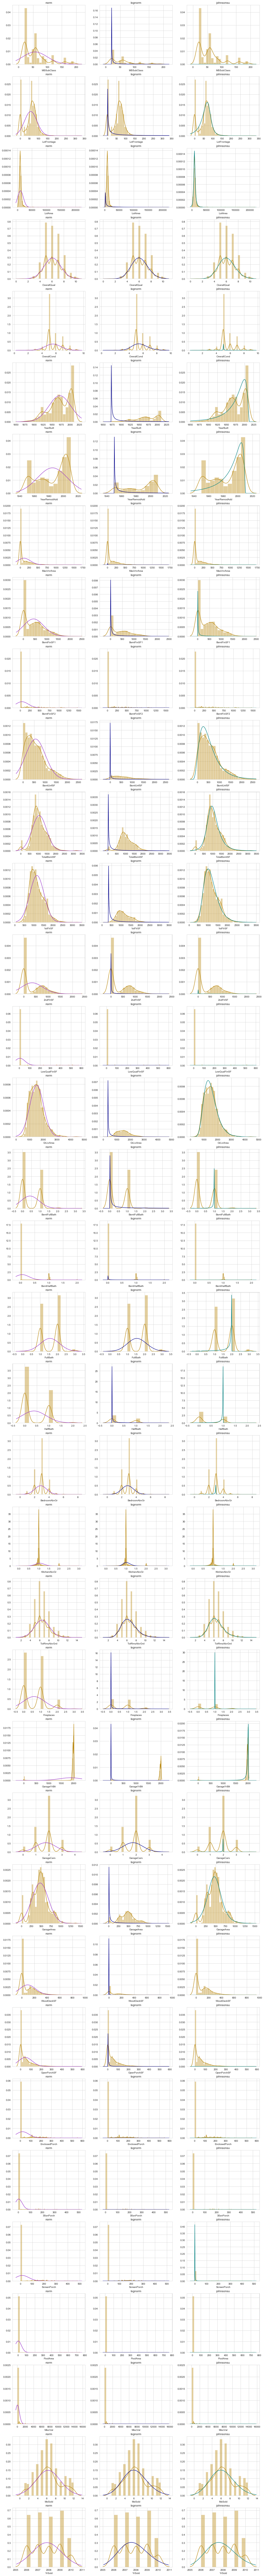

In [25]:
def num_distplot(df, features, fits, colors):
    with sns.axes_style("whitegrid"):
        nrows = len(features)
        ncols = len(fits)
        fig, axes = plt.subplots(nrows=nrows, 
                                 ncols=ncols, 
                                 figsize=(5*ncols, 4*nrows))
        plt.tight_layout(pad=3)
        for i, feature in enumerate(features):
            for j, fit in enumerate(fits):
                sns.distplot(df[feature], fit=fit, ax=axes[i, j], color='darkgoldenrod', fit_kws={"color":colors[j]})
                axes[i][j].set_xlabel(feature)
                axes[i][j].set_title(str(fit).split('.')[3].split()[0].split('_')[0])
        plt.show();

num_distplot(df=X_num, 
             features=num_feats, 
             fits=[stats.norm, stats.lognorm, stats.johnsonsu],
             colors=['darkorchid', 'darkblue', 'teal'])

Both Log and Johnson SU distribution fits well with most of the quantitative features. Johnson SU performs better when dealing with features with significant amount missing value (i.e., 0). Overall, Johnson SU works better. The following features will be transformed for linear regression using PowerTransformer:
1. LotFrontage
2. LotArea
3. BsmfUnfSF
4. TotalBsmtSF
5. 1stFlrSF
6. GrLivArea
7. GarageArea

No transformation will be performed to features with ordinal data (e.g., OverallQual).

In [26]:
power_feats = ['LotFrontage', 
              'LotArea', 
              'BsmtUnfSF', 
              'TotalBsmtSF', 
              '1stFlrSF', 
              'GrLivArea',
              'GarageArea']

## Step-5 Categorical Feature Encoding

### 5.0 - Set Data Type to `category` and Fill NA with `NA`

In [27]:
for c in cat_feats:
    X_cat.loc[:,c] = X_cat.loc[:, c].astype('category')
    if X_cat[c].isnull().any():       # return boool
        X_cat.loc[:, c] = X_cat[c].cat.add_categories(['NA'])
        X_cat.loc[:, c] = X_cat[c].fillna('NA');

/Users/kaizhao/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:635: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item_labels[indexer[info_axis]]] = value
/Users/kaizhao/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### 5.1 - Boxplot

First, using `Boxplot` to visualize partition of variance as initial step.

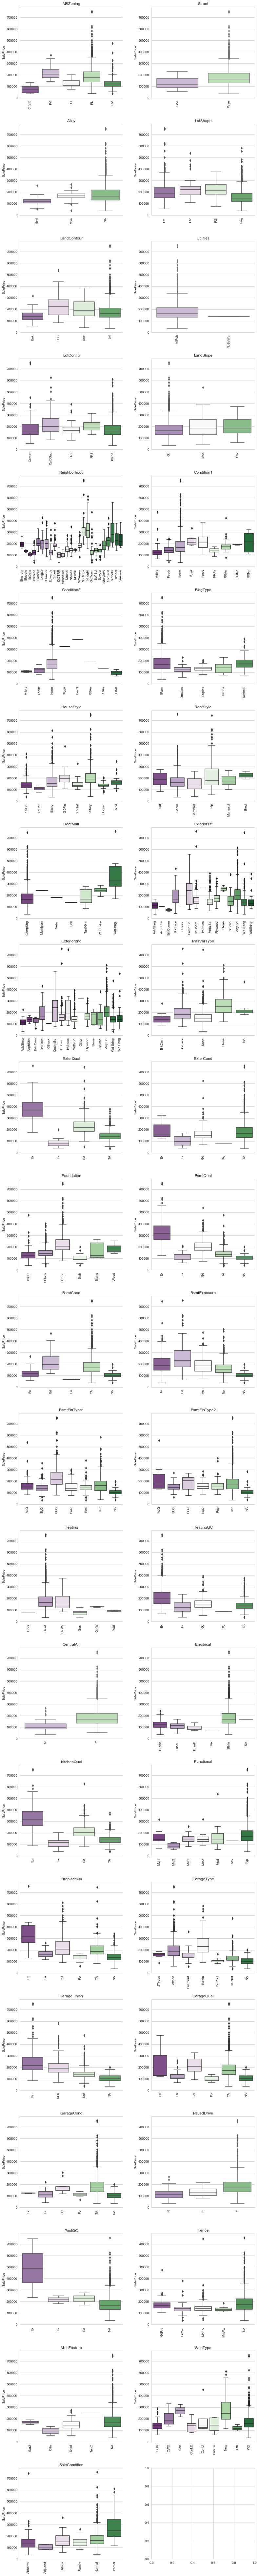

In [28]:
def cat_boxplot(df, features, label, ncols):
    with sns.axes_style("whitegrid"):
        nrows = int(np.ceil(len(features)/ncols))
        fig, axes = plt.subplots(nrows=nrows, 
                                 ncols=ncols, 
                                 figsize=(6*ncols, 5*nrows))
        plt.tight_layout(pad=6)
        axes = axes.ravel()
        for i, feat in enumerate(features):
                sns.boxplot(x=df[feat], 
                            y=label,
                            palette='PRGn',
                            ax=axes[i])
                axes[i].set_title(feat)
                axes[i].set_xlabel('')
                axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=90)
        plt.show();
        
cat_boxplot(X_cat, cat_feats, train['SalePrice'], 2)

Based on the Boxplot, the following categorical features seem to have significant impact to the home price:
1. `MSZoning`
2. `Neighborhood`
3. `Condition1` and `Condition2`
4. `Exterior1st` and `Exterior2nd`
5. `ExterQual`
6. `BsmtQual`
7. `CentralAir`
8. `KitchenQual`
9. `FireplaceQu`
10. `GarageFinish`
11. `PoolQC`

### 5.2 - 1-Way ANOVA

Second, using 1-way `ANOVA` test to explore and validate the partition of variance for features with 3 or more unique values. For those with 2 unique values, we will explore the unique value counts and decide whether to dummify.

In [175]:
# features for t-test
cat_ttest = X_cat.columns.values[X_cat.nunique()==2]
print(cat_ttest)
# features for 1-way ANOVA test
cat_anova = X_cat.columns.values[X_cat.nunique()>2]
print(cat_anova)

['Street' 'Utilities' 'CentralAir']
['MSZoning' 'Alley' 'LotShape' 'LandContour' 'LotConfig' 'LandSlope'
 'Neighborhood' 'Condition1' 'Condition2' 'BldgType' 'HouseStyle'
 'RoofStyle' 'RoofMatl' 'Exterior1st' 'Exterior2nd' 'MasVnrType'
 'ExterQual' 'ExterCond' 'Foundation' 'BsmtQual' 'BsmtCond' 'BsmtExposure'
 'BsmtFinType1' 'BsmtFinType2' 'Heating' 'HeatingQC' 'Electrical'
 'KitchenQual' 'Functional' 'FireplaceQu' 'GarageType' 'GarageFinish'
 'GarageQual' 'GarageCond' 'PavedDrive' 'PoolQC' 'Fence' 'MiscFeature'
 'SaleType' 'SaleCondition']


#### 1-way ANOVA test

In [176]:
# Add label to X_cat
X_cat.insert(X_cat.shape[1], 'SalePrice', train['SalePrice'])

In [177]:
# Calculate F_value and P_value
def anova_test(df, features, label):
    summary = {}
    results = {'f_value':[], 'p_value':[]}
    for f in features:
        model = ols(f'{label} ~ C({f})', df).fit()
        output = anova_lm(model)
        summary[f] = output
        results['f_value'].append(output.iloc[0,3])
        results['p_value'].append(output.iloc[0,4])
    return summary, pd.DataFrame(results, index=features)

summary, results = anova_test(X_cat, cat_anova, 'SalePrice')
results.sort_values(by='f_value', ascending=False, inplace=True)
results

f_value        p_value
ExterQual      458.235444  1.610719e-209
KitchenQual    416.220238  3.872591e-195
BsmtQual       322.495084  1.127319e-198
GarageFinish   214.580366  3.149921e-115
FireplaceQu    121.278696  2.192903e-107
Foundation     100.434148   4.318119e-91
HeatingQC       88.490748   2.336783e-67
MasVnrType      85.612973   2.363235e-65
GarageType      80.570571   4.147081e-87
Neighborhood    71.813053  1.694312e-225
BsmtExposure    65.018014   1.242930e-50
BsmtFinType1    64.934156   1.376018e-71
SaleCondition   46.370639   1.491929e-44
MSZoning        43.809632   9.364583e-35
PavedDrive      41.990741   1.864376e-18
LotShape        40.295496   5.172121e-25
SaleType        29.387966   8.733013e-43
GarageQual      25.753653   5.686021e-25
GarageCond      25.728652   6.014105e-25
BsmtCond        19.686785   8.537184e-16
HouseStyle      19.642000   2.932075e-25
Exterior1st     18.615091   2.567665e-43
Electrical      18.445465   8.522151e-18
RoofStyle       17.931512   2.746327e-17
Exterior2nd     17.501766   4.872752e-43
Alley           15.164734   3.032095e-07
Fence           13.428981   9.460894e-11
BldgType        13.002862   2.089576e-10
LandContour     12.923244   2.471854e-08
PoolQC          10.617456   6.608065e-07
ExterCond        8.792279   5.169077e-07
RoofMatl         7.831531   2.570714e-08
LotConfig        7.802816   3.205621e-06
BsmtFinType2     7.559754   5.306611e-08
Condition1       6.127472   8.625185e-08
Heating          4.255473   7.605984e-04
Functional       4.055166   4.875149e-04
MiscFeature      2.591829   3.510897e-02
Condition2       2.532201   1.366184e-02
LandSlope        1.953751   1.421131e-01

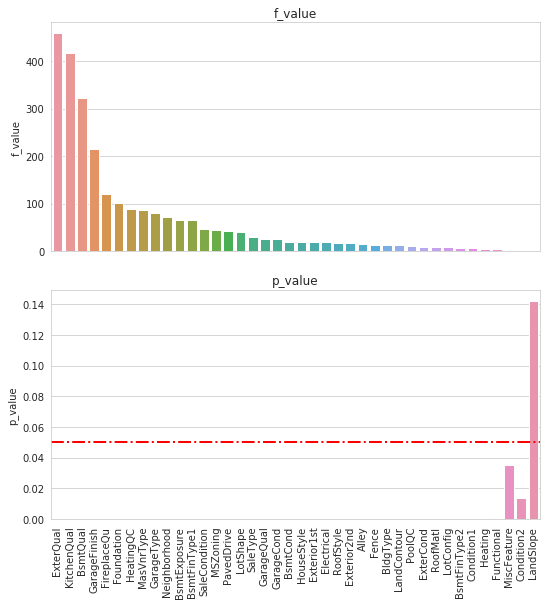

In [178]:
# Plot f_value and p_value
with sns.axes_style('whitegrid'):
    fit, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)
    plt.tight_layout(pad=3)
    sns.barplot(data=results,
                y='f_value',
                x=results.index,
                ax=axes[0])
    axes[0].set_title('f_value')
    sns.barplot(data=results,
                y='p_value',
                x=results.index,
                ax=axes[1])
    axes[1].axhline(y=0.05, color='red', linestyle='-.', linewidth=2)
    axes[1].set_title('p_value')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=90)
plt.show();

Based on the plots for `f_values` and `p_values`, the partition of variance for most of the categorial features (except `LandSlope`) with 3 or more levels are statistically siginificant. 

**Caveat**: ANOVA test serves as the first stop to determine the difference between levels. It usually requires the sample to be normally distributed among each level. For the purpose of data EDA, I did not verify the normality of the data (probably not normal). However, it is sufficient to serve the purpose that whether I should encode certain categorial features.

The following features will be not be encoded and elimited:
1. LandSlope

#### 2-level features.

`Street`, `Utility`, and `CentralAir` are independent categories that has two levels.

In [179]:
for feat in cat_ttest:
    print(train[feat].value_counts())

Pave    1452
Grvl       6
Name: Street, dtype: int64
AllPub    1457
NoSeWa       1
Name: Utilities, dtype: int64
Y    1363
N      95
Name: CentralAir, dtype: int64


#### Remove unwanted features
`Street` and `Utilities` are exremely unbalanced and sample size for one of the levels is too small. **Remove these two features**. `CentralAir` will be automatically encoded.

In [180]:
for_removal = {'LandSlope', 'Street', 'Utilities'}
cat_feats = list(set(cat_feats) - for_removal)
len(cat_feats)

40

### 5.3 - Encoding

The selected categorical features will be encoded using the rank of **mean** for each level within each feature.

In [181]:
def cat_encode(df, features, label, method='mean'):
    df_new = pd.DataFrame()
    for f in features:
        rank = df.groupby(f)[label].agg(method).rank().to_dict()
        df_new[f] = df[f].apply(lambda x: rank[x]) # rank starts 1. -1 to start from 0.
    return df_new.astype('int64')

X_cat_E = cat_encode(X_cat, cat_feats, 'SalePrice')
X_cat_E.head()

MSZoning  Electrical  MiscFeature  HeatingQC  Foundation  BsmtCond  \
Id                                                                       
1          4           6            4          5           6         4   
2          4           6            4          5           3         4   
3          4           6            4          5           6         4   
4          4           6            4          4           2         5   
5          4           6            4          5           6         4   

    RoofMatl  ExterQual  CentralAir  Fence  BsmtQual  Functional  \
Id                                                                 
1          2          3           2      5         4           7   
2          2          2           2      5         4           7   
3          2          3           2      5         4           7   
4          2          2           2      5         3           7   
5          2          3           2      5         4           7   

    BsmtFinType2  SaleCondition  GarageType  BldgType  Exterior1st  SaleType  \
Id                                                                             
1              6              5           6         5           12         5   
2              6              5           6         5            5         5   
3              6              5           6         5           12         5   
4              6              2           3         5            6         5   
5              6              5           6         5           12         5   

    LandContour  GarageQual  PavedDrive  FireplaceQu  Condition2  PoolQC  \
Id                                                                         
1             2           4           3            2           5       1   
2             2           4           3            4           5       1   
3             2           4           3            4           5       1   
4             2           4           3            5           5       1   
5             2           4           3            4           5       1   

    Condition1  HouseStyle  ExterCond  Heating  GarageCond  LotConfig  \
Id                                                                      
1            5           7          4        6           6          1   
2            3           6          4        6           6          2   
3            5           7          4        6           6          1   
4            5           7          4        6           6          3   
5            5           7          4        6           6          2   

    Neighborhood  Alley  BsmtFinType1  MasVnrType  LotShape  RoofStyle  \
Id                                                                       
1             17      3             7           3         1          2   
2             21      3             5           2         1          2   
3             17      3             7           3         2          2   
4             18      3             5           2         2          2   
5             25      3             7           3         2          2   

    Exterior2nd  GarageFinish  BsmtExposure  KitchenQual  
Id                                                        
1            13             3             2            3  
2             6             3             5            2  
3            13             3             3            3  
4             9             2             2            3  
5            13             3             4            3

## Step 6 - Correlation

### 6.0 - Combine X_cat and X_num

In [182]:
train_update = pd.concat([X_num, X_cat_E], axis=1)
train_update.insert(train_update.shape[1], 'SalePrice', train['SalePrice'])

In [183]:
train_update.tail()

MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  YearBuilt  \
Id                                                                            
1456          60         62.0     7917            6            5       1999   
1457          20         85.0    13175            6            6       1978   
1458          70         66.0     9042            7            9       1941   
1459          20         68.0     9717            5            6       1950   
1460          20         75.0     9937            5            6       1965   

      YearRemodAdd  MasVnrArea  BsmtFinSF1  BsmtFinSF2  BsmtUnfSF  \
Id                                                                  
1456          2000         0.0           0           0        953   
1457          1988       119.0         790         163        589   
1458          2006         0.0         275           0        877   
1459          1996         0.0          49        1029          0   
1460          1965         0.0         830         290        136   

      TotalBsmtSF  1stFlrSF  2ndFlrSF  LowQualFinSF  GrLivArea  BsmtFullBath  \
Id                                                                             
1456          953       953       694             0       1647             0   
1457         1542      2073         0             0       2073             1   
1458         1152      1188      1152             0       2340             0   
1459         1078      1078         0             0       1078             1   
1460         1256      1256         0             0       1256             1   

      BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  KitchenAbvGr  \
Id                                                                   
1456             0         2         1             3             1   
1457             0         2         0             3             1   
1458             0         2         0             4             1   
1459             0         1         0             2             1   
1460             0         1         1             3             1   

      TotRmsAbvGrd  Fireplaces  GarageYrBlt  GarageCars  GarageArea  \
Id                                                                    
1456             7           1       1999.0           2         460   
1457             7           2       1978.0           2         500   
1458             9           2       1941.0           1         252   
1459             5           0       1950.0           1         240   
1460             6           0       1965.0           1         276   

      WoodDeckSF  OpenPorchSF  EnclosedPorch  3SsnPorch  ScreenPorch  \
Id                                                                     
1456           0           40              0          0            0   
1457         349            0              0          0            0   
1458           0           60              0          0            0   
1459         366            0            112          0            0   
1460         736           68              0          0            0   

      PoolArea  MiscVal  MoSold  YrSold  MSZoning  Electrical  MiscFeature  \
Id                                                                           
1456         0        0       8    2007         4           6            4   
1457         0        0       2    2010         4           6            4   
1458         0     2500       5    2010         4           6            2   
1459         0        0       4    2010         4           4            4   
1460         0        0       6    2008         4           6            4   

      HeatingQC  Foundation  BsmtCond  RoofMatl  ExterQual  CentralAir  Fence  \
Id                                                                              
1456          5           6         4         2          2           2      5   
1457          3           3         4         2          2           2      3   
1458          5           4         5     

### 6.1 - Pearson and Spearman Correlation

Pearson and Spearman correlations are used to explore the correlation between `SalePrice` and every features.

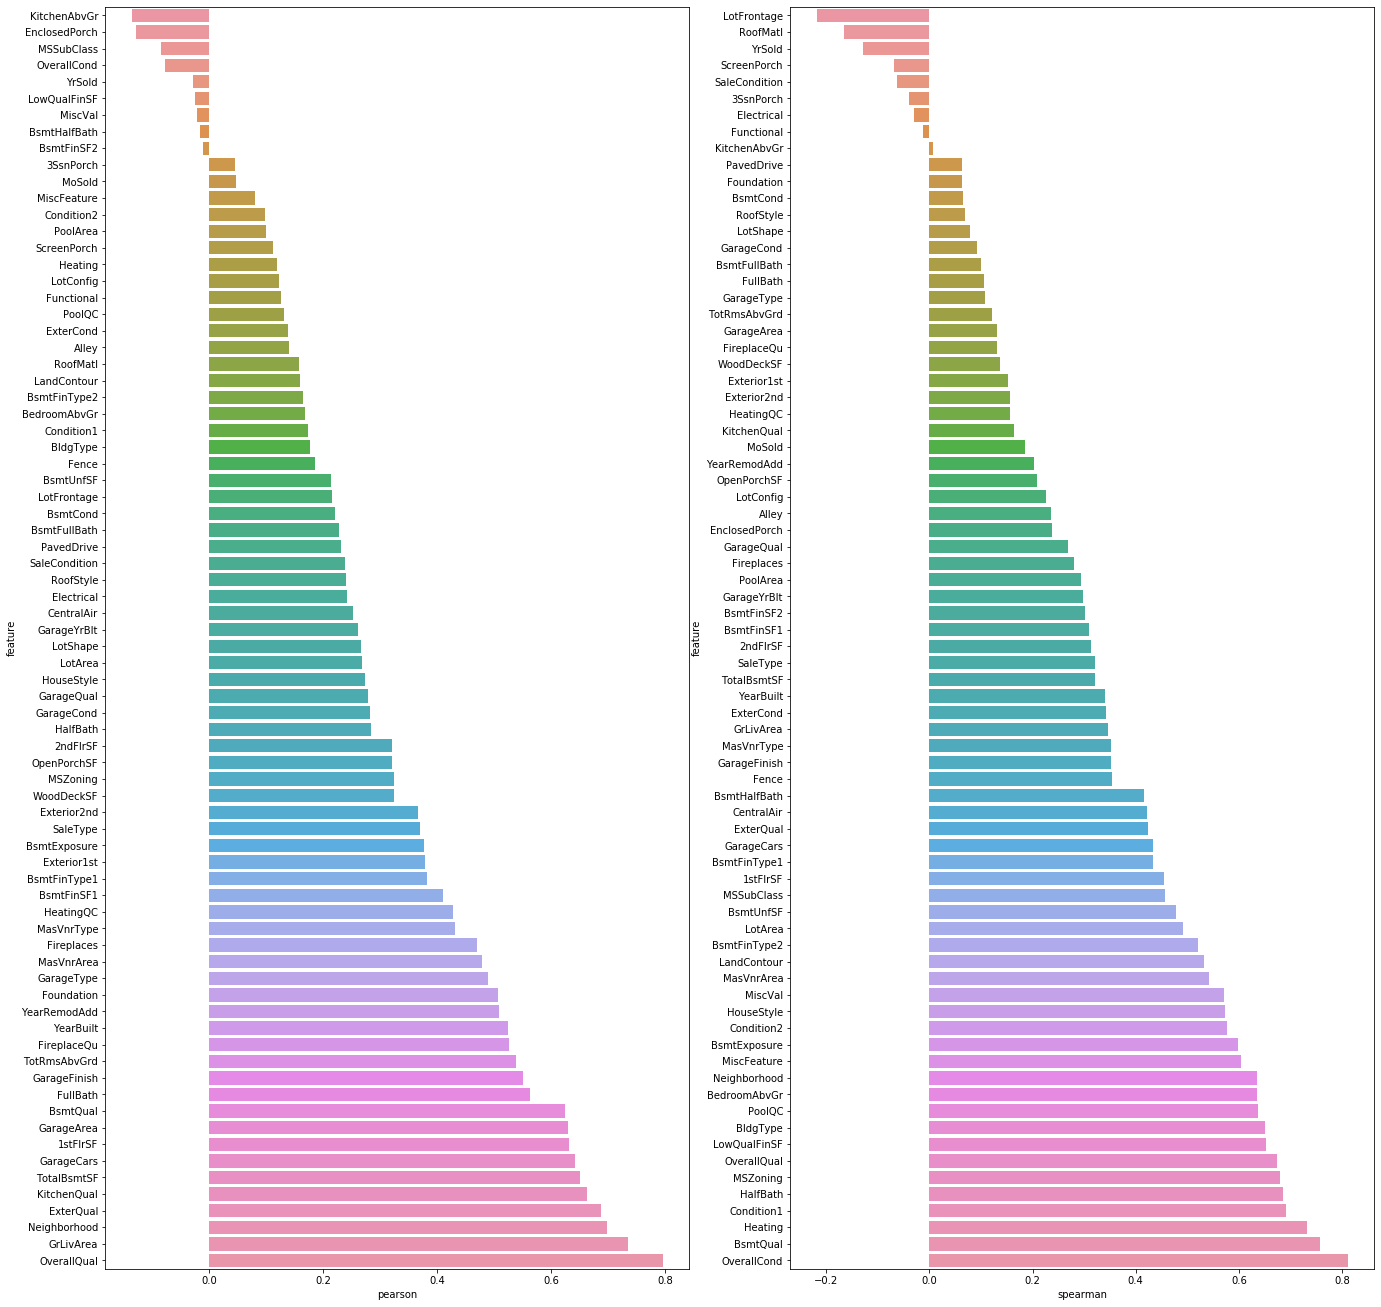

In [184]:
# code from https://www.kaggle.com/dgawlik/house-prices-eda
def correlation(df, features, label, corrs):
    r = pd.DataFrame()
    r['feature'] = features
    fig, axes = plt.subplots(1, len(corrs), figsize=(20, 0.26*len(features)))
    plt.tight_layout(pad=7)
    for i, corr in enumerate(corrs):
        r[corr] = [df[f].corr(df[label], corr) for f in features]
        r = r.sort_values(corr)
        sns.barplot(data=r, y='feature', x=corr, orient='h', ax=axes[i])
features = num_feats + cat_feats
correlation(train_update, features, 'SalePrice', ['pearson', 'spearman'])

Both `Pearson` and `Spearman` correlation shows `OverallQuall`

### 6.2 - Heatmap

Using heatmap to explore the correlation among the features. Ideally, feature should be independent from one another for multivariate linear regression.  

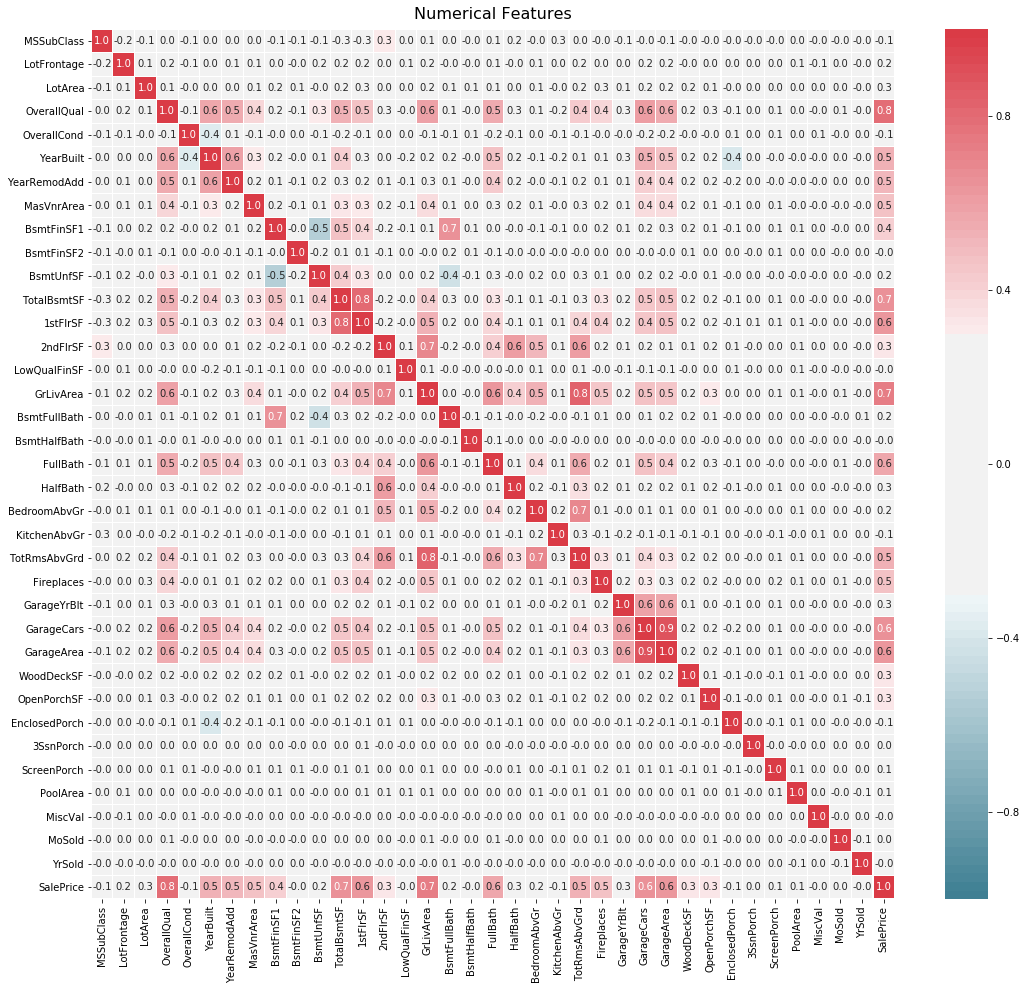

In [185]:
plt.figure(figsize=(18, 16))
heatmap_scheme = sns.diverging_palette(220, 10, sep=80, n=100)
corr = train_update[num_feats+['SalePrice']].corr()
sns.heatmap(corr, annot=True, annot_kws=None, fmt=".1f",                                   # Annotate format
            cmap=heatmap_scheme, vmin=-1, vmax=1,                                          # Color bar scale
            linewidths=0.1, linestyle='-.')
plt.title('Numerical Features', fontsize=16, pad=10);

For numeric features, the following features are highly correlated to each other:
**Obvious Ones**:
1. `GarageArea` with `GarageCars`
2. `GrLivArea` with `TotRmsAbvGrd`, `FullBath`, `BedroomAbvGr`, `Fireplaces`, `GarageArea`, `GarageCars`, `1stFlrSF`, `2ndFlrSF`, `YearBUilt`, and `OverallQual`
3. `1stFlrSF` with `TotalBsmtSF`
4. `OverallQual` with `YearRemodAdd`
**Interesting ones**:
`YearBuilt` with `YearRemodAdd`

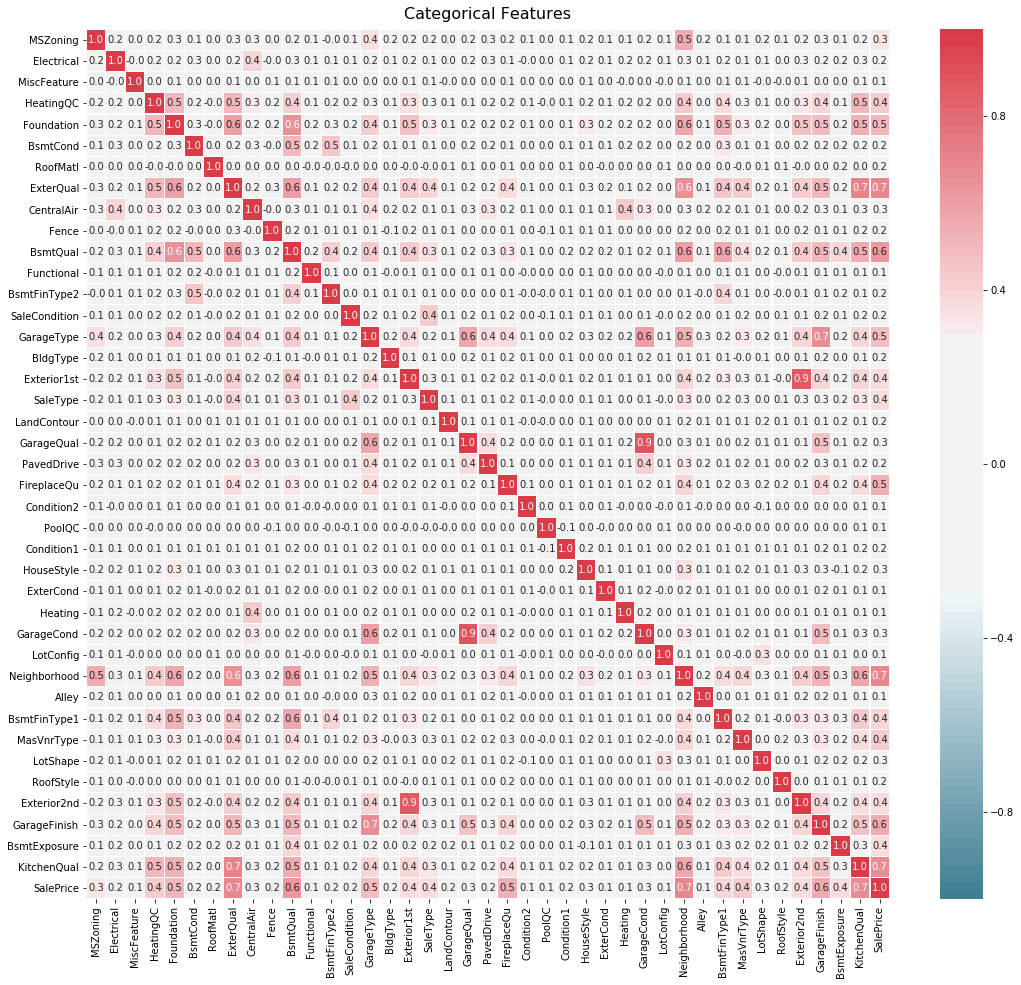

In [186]:
plt.figure(figsize=(18, 16))
heatmap_scheme = sns.diverging_palette(220, 10, sep=80, n=100)
corr = train_update[cat_feats + ['SalePrice']].corr()
sns.heatmap(corr, annot=True, annot_kws=None, fmt=".1f",                                   # Annotate format
            cmap=heatmap_scheme, vmin=-1, vmax=1,                                          # Color bar scale
            linewidths=0.1, linestyle='-.')
plt.title('Categorical Features', fontsize=16, pad=10);

For categorical features, the following features are highly correlated to each other:
**Obvious Ones**:
1. `Exterior1st` with `Exterior2nd`
2. `GarageType` with `GarageQual` with `GarageCond` with `GarageFinish`
3. `Neighborhood` with `ExterQual`, `GarageFinish`, `GarageType`, `Foundation`, `BsmtQual`, `KitchenQual`, and `MSZoning`.
4. `OverallQual` with `YearRemodAdd`

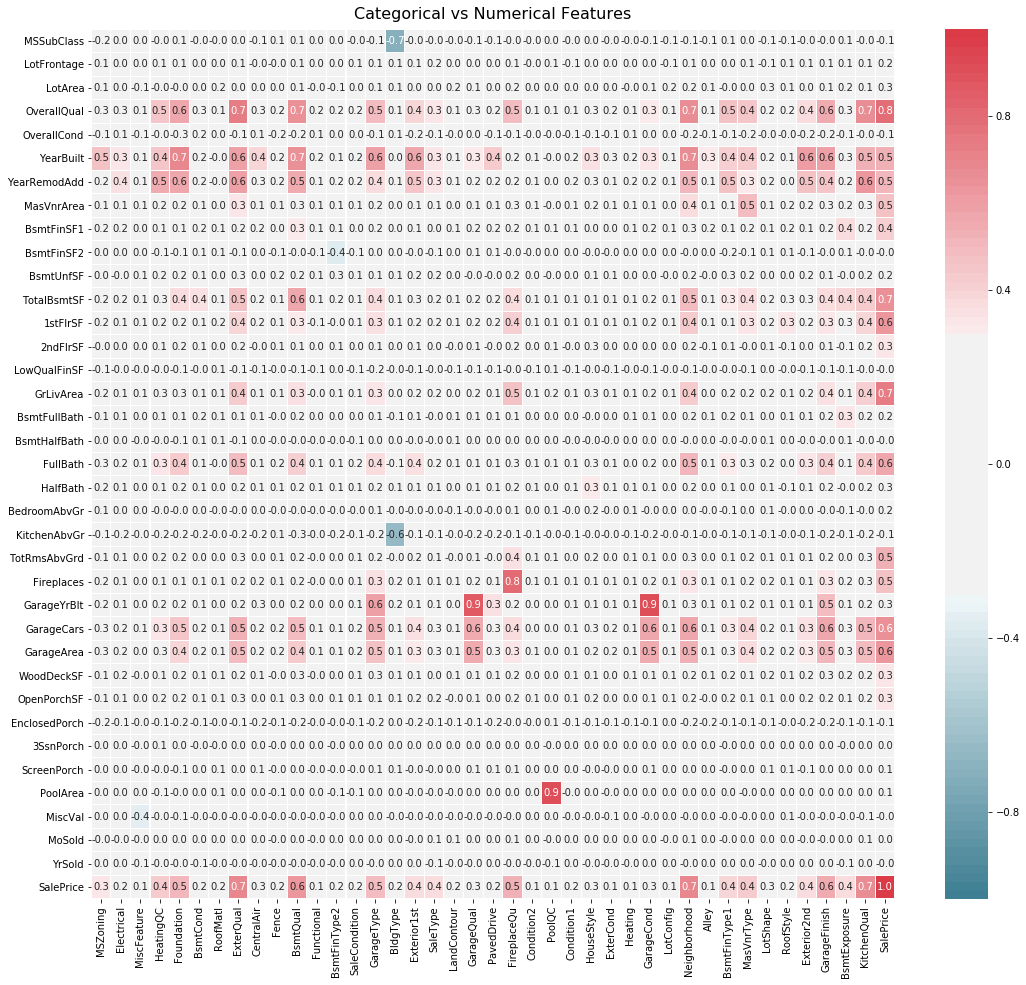

In [187]:
corr = pd.DataFrame(np.zeros([len(num_feats)+1, len(cat_feats)+1]), 
                    index=num_feats+['SalePrice'],
                    columns=cat_feats+['SalePrice'])
for num_feat in num_feats+['SalePrice']:
    for cat_feat in cat_feats+['SalePrice']:
        corr.loc[num_feat, cat_feat] = train_update[num_feat].corr(train_update[cat_feat])
        
plt.figure(figsize=(18, 16))
heatmap_scheme = sns.diverging_palette(220, 10, sep=80, n=100)
sns.heatmap(corr, annot=True, annot_kws=None, fmt=".1f",                                   # Annotate format
            cmap=heatmap_scheme, vmin=-1, vmax=1,                                          # Color bar scale
            linewidths=0.1, linestyle='-.')
plt.title('Categorical vs Numerical Features', fontsize=16, pad=10);

When numerical vs categorical features, the following features are highly correlated to each other:
**Obvious Ones**:
1. `GarageYrBlt` with `GarageQual`, `GarageType`, and `GarageFinish`
2. `Neighborhood` with `GarageArea`, `GarageCars`, `YearBuilt`, and `OverallQual`
3. `OveralQual` with `Neighborhood`, `KitchenQual`, `BsmtQual`, `Foundation`, `GarageFinish`, and `ExterQual`
4. `Fireplace` with `FireplaceQu`
5. `PoolArea` with `PoolQC`

Based on the **heatmap**, many featuers are correlated among each other. Therefore, the following three modeling appraoches are proposed.
1. Linear Regression with feature selection through LASSO regularization (auto-feature-selection)
2. Linear Regression with feature extraction through Principal Componend Analysis (PCA)
3. Random Forest
4. XGBoost

### 6.3 - Pairplot

In [188]:
train_update.insert(train_update.shape[1],'log_SalePrice', y)

/Users/kaizhao/anaconda3/lib/python3.7/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


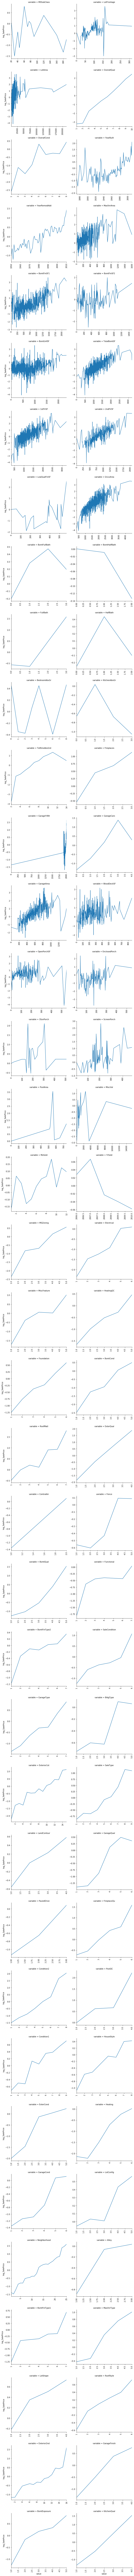

In [189]:
def pairplot(x, y, **kwargs):
    ax = plt.gca()
    ts = pd.DataFrame({'x_label': x, 'val': y})
    ts = ts.groupby('x_label').mean()
    ts.plot(ax=ax)
    plt.xticks(rotation=90)
    
f = pd.melt(train_update, id_vars=['log_SalePrice'], value_vars = num_feats + cat_feats)
g = sns.FacetGrid(f, col="variable",  col_wrap=2, sharex=False, sharey=False, size=5)
g = g.map(pairplot, "value", "log_SalePrice")

In [190]:
train.columns

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'Wo

Based on the above pairplot, the following features may benefit from adding a 3rd degree polynomial term (s-shaped curve) though it may leads to overfitting.

In [191]:
poly_feats = ['BldgType',
             'ExterCond',
             'Exterior2nd',
             'BsmtExposure',
             'BsmtFinType1',
             'BsmtFinType2',
             'Fence',
             'Functional',
             'PoolQC',
             'SaleCondition',
             'Heating',
             'GarageQual',
             'GarageCond',
             'MiscFeature'
             ]

## Step-7 Store Features

In [192]:
%store train       # after drop the outliers
%store power_feats # numerical features to transform using PowerTransformer
%store num_feats   # all numerical features
%store cat_feats   # categorical features to encode based on the mean of `SalePrice`
%store poly_feats  # features to add polynomial terms (after transformation and encoding)

Stored 'train' (DataFrame)
Stored 'power_feats' (list)
Stored 'num_feats' (list)
Stored 'cat_feats' (list)
Stored 'poly_feats' (list)
